<a href="https://colab.research.google.com/github/GiovanniBurbi/Neural-Collaborative-Filtering/blob/main/NeuralCollaborativeFiltering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural Collaborative Filtering**

# *1. Import Libraries and Tools*

In [ ]:
import csv
import heapq
import math
import random
import pickle
import multiprocessing as mp
from enum import Enum
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras import regularizers, initializers
import scipy.sparse as sp
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from operator import itemgetter
from google.colab import files
import urllib

# *2. Project Parameters*

Define Enum classes

In [ ]:
# Factors represent the latent factors or the predictive factors, based on the model used
# If it's used on the GMF model, they represent the latent factors
# else, in MLP model, they represent the predictive factors

class Factors(Enum):
  EIGHT = 8 
  SIXTEEN = 16
  THIRTYTWO = 32
  SIXTYFOUR = 64

In [ ]:
class Optimizer(Enum):
  ADAM = 0
  SGD = 1

In [ ]:
class Dataset(Enum):
  MOVIELENS = 'MovieLens'
  PINTEREST = 'Pint'

In [ ]:
class Extension(Enum):
  CSV = '.csv'
  H5 = '.h5'

In [ ]:
class Model(Enum):
  GMF = 'GMF'
  MLP = 'MLP'
  NeuMF = 'NeuMF'

Define project parameters

In [ ]:
# Datasets file name
datasetMovielens = 'dataset/movielens.dat'
datasetPinterest = 'dataset/pinterest.dat'

# Number of negative samples for each positive sample in train set
numNegSamplesTrain = 4

# Number of negative samples for each positive sample in test set
numNegSamplesTest = 99

# Learning rate
learningRateOptions = [0.0001 ,0.0005, 0.001, 0.005]
learningRate = learningRateOptions[2]

# Batch size
batchSizeOptions = [128, 256, 512, 1024]
batchSize = batchSizeOptions[1]

# Top-K reccomendation, k value
topK = 10

# Number of epochs for model training
epochs = 2

# Flag to save the weights of the model
saveModelWeights = True

# Rate of metrics evaluations (evaluate every 'evaluationRate' epochs the metrics for the model) 
evaluationRate = 2


# Flag to enable the use of pre-train model for NeuMF
preTrain = False

# Number of hidden layers for MLP model
nHiddenLayers = 3

# Hyper-parameter of the trade-off between GMF and MLP models for the NeuMF pre-train version
alfa = 0.5

# If you want a new test set generated, set the next flag to True!
newGeneration = False

Define models factors

In [ ]:
# Set the latent factor and predictive factor for the GMF and MLP layers
latentFactor = Factors.SIXTEEN.value
predictiveFactor = Factors.SIXTEEN.value

# Generate an id for the couple latent factor - predictive factor used to create the NeuMF model
neuID = 'Latent{}Pred{}'.format(latentFactor, predictiveFactor)

# Used when pre-train flag is True
neuIDPretrain = neuID + 'Pretrain'

# *3. Dictionaries Declaration*

## Models Dictionaries

In [ ]:
# Initialize the dict with the GMF models based on the latent factor
GMFModels = {}

In [ ]:
# Initialize the dict with the GMF models based on the latent factor
MLPModels = {}

In [ ]:
# Initialize the dict with the NeuMF models based on the latent factor
NeuMFModels = {}

## Metrics Dictionaries

In [ ]:
# Dictionary to store the metrics of the models based on the latent factor used

GMFmetricsDict = {}

In [ ]:
# Dictionary to store the metrics of the models based on the latent factor used

MLPmetricsDict = {}

In [ ]:
# Dictionary to store the metrics of the models based on the latent factor and predictive factor used

NeuMFmetricsDict = {}

# *4. Dataset Generic Methods*

In [ ]:
# Method to fetch the dataset as a pandas DataFrame based on a filepath
# It returns the dataset and the number of dinstict users and items

def fetchDataset(filepath):
  print('Reading the dataset file...')

  # Read dataset file
  dataset = pd.read_csv(filepath,sep=r'::', engine='python',header=None)
  print('Dataset file has been read successfully!')

  # Get total number of distint users id and items id
  nUsers = dataset[0].max()
  nItems = dataset[1].max()

  print('The dataset contains {} interactions of {} users and {} items\n'.format(dataset.shape[0], nUsers, nItems))

  return dataset, nUsers, nItems

In [ ]:
# Method that generates the sparse interaction matrix from the dataset data
# This matrix has dimensions of 'number of users' x 'number of items'
# if an user u has interacted (reviewed) with a certain item i the
# position (u, i) of the generated matrix will contain the value 1, otherwise 0 

def createInteractionMatrix(dataset, nUsers, nItems):
  print('Initialize the sparse matrix with dimension {}x{}'.format(nUsers, nItems))

  # Initialize matrix of interaction user-item
  matrix = sp.dok_matrix(((nUsers),(nItems)), dtype=np.uint)

  print('Populating the sparse matrix adding the interactions between users and items...')
  # Each interaction between an user and an item has value 1 in the matrix, 0 if it's not present
  for i in range(len(dataset[0])):
    # Dataset is a pandas DataFrame (index minus one because in the dataset the user and items ids start from 1)
    matrix[dataset[0][i] - 1, dataset[1][i] - 1] = 1
  
  print('Interaction matrix has been successfully created!\n')

  return matrix

In [ ]:
# Method that, given the train set, generates the vectors that will be the input of a model during the training process
# It also adds 'negSamples' negative samples generated randomly for each positive sample
# For each user the generated negative samples are distint from each other (no replicas) if the user has done less 
# than a certain number of reviews, otherwise there will be some negative samples replicated for that user

def createModelTrainVectors(interactMatrix, trainSet, numUsers, numItems, negSamples):
  # Get lists of user ids and item ids based on the interactions data
  # The same position in each list represent an interaction between the two elements
  userInteract = trainSet[:, 0].tolist()
  itemInteract = trainSet[:, 1].tolist()

  # Generate a bucket with all the possible item ids
  itemsBucket = np.arange(0, numItems, 1, dtype='uint16').tolist()

  # Get the number of user-item interactions(reviews) 
  numInteract = trainSet.shape[0]

  # Initialize the list of label that represents if a certain user-item interaction
  # is a positive sample (value 1) or a negative sample (value 0)
  # Initially the train set has only positive interactions
  label = np.ones(numInteract).tolist()

  # The train set is ordered but user id
  # This variable stores the old user id, initialized with the first user id 
  oldId = trainSet[0, 0]

  print('Starting the generation of new negative samples...')

  # For each positive sample(interaction), it adds a certain number of negative random samples
  for i in range(numInteract):
    # Get the current review's user id
    userId = trainSet[i, 0]  

    # if the current user id is the same as the old one, go ahead
    # else change old user id and generate a new item bucket for the new user id
    if(userId != oldId):      
      oldId = userId
      itemsBucket = np.arange(0, numItems, 1, dtype='uint16').tolist()
    
    # Add 'negSamples' negative samples
    for j in range(negSamples):
      # If the bucket for a certain user is empty, generate a new full bucket
      # There will be some replicas from now on for that particular user
      if(len(itemsBucket) == 0):
        itemsBucket = np.arange(0, numItems, 1, dtype='uint16').tolist()

      # Generate a random index for the bucket based on its current lenght 
      bucketIndex = random.randint(0, len(itemsBucket)-1)
      # Pop the item id from the bucket at the given index
      newItemId = itemsBucket.pop(bucketIndex)
     
     # Verify that the new item id is not already a positive sample for the user
      while (interactMatrix[userId, newItemId] != 0):
        # If the bucket empties while inside this loop, generate a new full bucket
        if(len(itemsBucket) == 0):
          itemsBucket = np.arange(0, numItems, 1, dtype='uint16').tolist()
        
        # if it was a positive sample, generate a new index and then a new item id
        # and repeat the while loop control
        bucketIndex = random.randint(0, len(itemsBucket)-1)
        newItemId = itemsBucket.pop(bucketIndex)           
      
      # Add the new negative user-item interaction filling userInteract with the user id
      # and itemInteract with the generated item id.
      # lastly, add an element with value 0 in the respective position in the label list  
      userInteract.append(userId)
      itemInteract.append(newItemId)
      label.append(0)
  
  print('Successfully created model\'s training input vectors with negative samples')
  return np.array(userInteract),np.array(itemInteract),np.array(label)


In [ ]:
# Method that given the test set generates the vectors that will be the input of a model's prediction
# It adds 'negSamples' negative samples generated randomly for each test entry (one entry for each user)
# For each user it generates distint negative samples (no replicas)

def createTestSamples(interactMatrix, testSet, numItems, negSamples):
  # Retrieve the items of the test set
  itemInteract = testSet[:, 1].tolist()

  # Initialize the list of samples for the test set
  testSamples = []

  # Get the number of total interactions (total reviews) in the test set
  # it's equal to the number of distint users
  numInteract = testSet.shape[0]
  
  print('Starting the generation of new negative samples...')

  # For each positive sample, it adds a certain number of negative random samples
  # The test set is composed of one positive sample for each user
  # Therefore, the number of interaction user-item in the test set is equal to the number of users
  for userId in range(numInteract):
    # Create a list of test samples for a certain user (numNegSamplesTest  + 1 positive sample)
    testSamplesUser = []  

    for j in range(negSamples):

      # Generate a random item id      
      newItemId = random.randint(0, numItems - 1)
      # Keep generate ids until it finds an id that a certain user doesn't have interact with and
      # it must be different from other negative samples generated for that particular user
      while interactMatrix[userId, newItemId] != 0 | (newItemId in testSamplesUser):
        newItemId = random.randint(0, numItems - 1)

      # Append the new item id of a negative sample in the test samples array of user id
      testSamplesUser.append(newItemId)

    # Append as last element the positive sample in test set of user id 
    testSamplesUser.append(itemInteract[userId])

    # Add the list of test samples of id in the array of test items
    testSamples.append(testSamplesUser)
  
  testSamples = np.array(testSamples)

  print('Created neural network model\'s test input samples with the addition of negative instances')

  return testSamples

# Choose one between the two following datasets:



# 5.1 *MovieLens*

In [ ]:
datasetName = Dataset.MOVIELENS.value

In [ ]:
!mkdir dataset

# Fetch MovieLens dataset
!wget -nc https://raw.githubusercontent.com/GiovanniBurbi/Neural-Collaborative-Filtering/main/Dataset/movielens.dat -P dataset/

# Fetch MovieLens Test set
!wget -nc https://raw.githubusercontent.com/GiovanniBurbi/Neural-Collaborative-Filtering/main/Dataset/TestSetMovieLens.csv -P dataset/

--2022-08-12 07:32:39--  https://raw.githubusercontent.com/GiovanniBurbi/Neural-Collaborative-Filtering/main/Dataset/movielens.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24594131 (23M) [text/plain]
Saving to: ‘dataset/movielens.dat’

movielens.dat       100%[===================>]  23.45M  --.-KB/s    in 0.1s    

2022-08-12 07:32:40 (196 MB/s) - ‘dataset/movielens.dat’ saved [24594131/24594131]

--2022-08-12 07:32:40--  https://raw.githubusercontent.com/GiovanniBurbi/Neural-Collaborative-Filtering/main/Dataset/TestSetMovieLens.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connecte

## Methods

In [ ]:
# Method to split dataset in Train and Test set
# Test set follows the protocol 'leave-one-out'; meaning that contains the most recent
# review of each user
# User and item ids have been re-scaled so that they will start from id 0

def createTrainAndTestSetMovieLens(dataset, nUsers):
  
  # Copy the dataset in a DataFrame so that modifications will not be reflected to the original dataset
  # Make sure the dataset is a pandas DataFrame
  if not (isinstance(dataset, pd.DataFrame)):
    df = pd.DataFrame(dataset, dtype='uint32', copy=True)
  else: df = dataset.copy()

  # Initialize test set list, it will contain the most recent interaction of each user
  testSet = []

  # Initialize list of indexes to remove from dataset to create the train set
  dropIndexes = []


  print('Creating the test set with the most recent interaction of each user...')
  for i in range(nUsers):
    # Find the max timestamp for each user
    maxTimestampPerUser = df.loc[df[0] == i + 1][3].max()
    # Find the row with the max timestamp for that user
    rowWithMaxTimestamp = df.loc[(df[0] == i + 1) & (df[3] == maxTimestampPerUser)]
    
    # Index of the row
    indexRow = rowWithMaxTimestamp.index[0]

    # Update list of indexes to drop from dataset to create the train set
    dropIndexes.append(indexRow)

    # Convert the row in a numpy array,
    # reduce item and user item by 1 so that we have ids that start with 0
    # If we have more timestamps with the same value take the first one
    npRow = rowWithMaxTimestamp.to_numpy()[0] - [1, 1, 0, 0]

    # Append the row to the test set
    testSet.append(npRow)

  # Drop all rows from data frame in indexesDrop list
  df.drop(index=dropIndexes, inplace=True)
  print('Test set successfully created!')

  print('Dataset has been successfully splitted in train and test set!')
  # Convert test set in a numpy array
  npTestSet = np.array(testSet)
  print('The test set has {} entries'.format(npTestSet.shape[0]))
  
  # Convert what remains of the data frame in a numpy array,
  # it also subtracts 1 to the first two columns of each row
  # this is to have all ids start from 0 and not 1 like in the original dataset 
  npTrainSet = df.to_numpy() - [1, 1, 0, 0]
  print('train set has {} entries'.format(npTrainSet.shape[0]))

  return npTrainSet, npTestSet


## Calls

In [ ]:
dataset, nUsers, nItems = fetchDataset(datasetMovielens)

Reading the dataset file...
Dataset file has been read successfully!
The dataset contains 1000209 interactions of 6040 users and 3952 items



In [ ]:
interactionMatrix = createInteractionMatrix(dataset, nUsers, nItems)

Initialize the sparse matrix with dimension 6040x3952
Populating the sparse matrix adding the interactions between users and items...
Interaction matrix has been successfully created!



In [ ]:
trainSet, testSet = createTrainAndTestSetMovieLens(dataset, nUsers)

Creating the test set with the most recent interaction of each user...
Test set successfully created!
Dataset has been successfully splitted in train and test set!
The test set has 6040 entries
train set has 994169 entries


In [ ]:
if newGeneration:
  testWithNegSamples = createTestSamples(interactionMatrix, testSet, nItems, numNegSamplesTest)
else:
  testWithNegSamples = pd.read_csv('dataset/TestSetMovieLens.csv', header=None)
  testWithNegSamples = testWithNegSamples.to_numpy()


# 5.2 *Pinterest*

In [ ]:
datasetName = Dataset.PINTEREST.value

In [ ]:
!mkdir dataset

# Fetch Pinterest dataset
!wget -nc https://raw.githubusercontent.com/GiovanniBurbi/Neural-Collaborative-Filtering/main/Dataset/pinterest.dat -P dataset/

# Fetch Pinterest Test set
!wget -nc https://raw.githubusercontent.com/GiovanniBurbi/Neural-Collaborative-Filtering/main/Dataset/TestSetPinterest.csv -P dataset/

## Methods

In [ ]:
# Method to split dataset in Train and Test set
# Test set follows the protocol 'leave-one-out'; meaning that contains the most recent
# review of each user

def createTrainAndTestSetPinterest(dataset, nUsers):
  # Copy the dataset in a DataFrame so that modification will not be reflected to the real dataset
  
  # Make sure the dataset is a pandas DataFrame
  if not (isinstance(dataset, pd.DataFrame)):
    df = pd.DataFrame(dataset, dtype='uint32', copy=True)
  else: df = dataset.copy()

  # Initialize test set list, it will contain the most recent interaction of each user
  testSet = []

  # Initialize list of indexes to remove from dataset to create the train set
  dropIndexes = []


  print('Creating the test set with the most recent interaction of each user...')
  for i in range(nUsers):
    
    # get index last review of user i
    indexRow = dataset.loc[dataset[0] == i + 1].index[-1]

    # Update list of indexes to drop from dataset to create the train set
    dropIndexes.append(indexRow)

    # Convert the row in a numpy array,
    # reduce item and user item by 1 so that we have ids that start with 0
    npRow = dataset.iloc[indexRow].to_numpy() - [1, 1, 0, 0]

    # Append the row to the test set
    testSet.append(npRow)

  # Drop all rows from data frame in indexesDrop list
  df.drop(index=dropIndexes, inplace=True)
  print('Removed the test samples from the train set')

  print('Dataset has been successfully splitted in train and test set!')
  # Convert test set in a numpy array
  npTestSet = np.array(testSet)
  print('The test set has {} row(reviews) and {} columns(fields)'.format(npTestSet.shape[0], npTestSet.shape[1]))
  
  # Convert what remains of the data frame in a numpy array,
  # it also subtracts 1 to the first two columns of each row
  # this is to have all ids start from 0 and not 1 like in the original dataset 
  npTrainSet = df.to_numpy() - [1, 1, 0, 0]
  print('train set has {} row(reviews) and {} columns(fields)'.format(npTrainSet.shape[0], npTrainSet.shape[1]))
  print('User and item ids have been re-scaled so that they will start from id 0\n')

  return npTrainSet, npTestSet


## Calls

In [ ]:
dataset, nUsers, nItems = fetchDataset(datasetPinterest)

Reading the dataset file...
Dataset file has been read successfully!
The dataset contains 1500809 interactions of 55187 users and 9916 items



In [ ]:
interactionMatrix = createInteractionMatrix(dataset, nUsers, nItems)

Initialize the sparse matrix with dimension 55187x9916
Populating the sparse matrix adding the interactions between users and items...
Interaction matrix has been successfully created!



In [ ]:
trainSet, testSet = createTrainAndTestSetPinterest(dataset, nUsers)

Creating the test set with the most recent interaction of each user...
Removed the test samples from the train set
Dataset has been successfully splitted in train and test set!
The test set has 55187 row(reviews) and 4 columns(fields)
train set has 1445622 row(reviews) and 4 columns(fields)
User and item ids have been re-scaled so that they will start from id 0



In [ ]:
if newGeneration:
  testWithNegSamples = createTestSamples(interactionMatrix, testSet, nItems, numNegSamplesTest)
else:
  testWithNegSamples = pd.read_csv('TestSetPinterest.csv', header=None)
  testWithNegSamples = testWithNegSamples.to_numpy()


# *6. Data Visualization*

In [ ]:
pd.set_option('display.min_rows', 50)
pd.set_option('display.max_columns', 26)

tags = ['userId', 'itemId', 'rating', 'timestamp']

## Dataset

In [ ]:
# Original dataset visualization

dataset.columns = tags
display(dataset)

,userId,itemId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
6,1,1287,5,978302039
7,1,2804,5,978300719
8,1,594,4,978302268
9,1,919,4,978301368


## Interaction Matrix

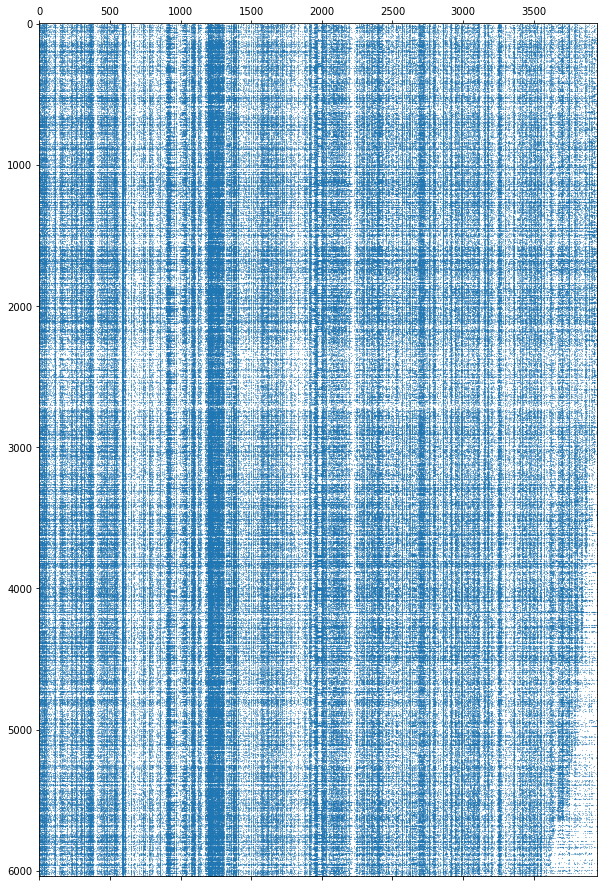

In [ ]:
# Dataset's interaction matrix visualization

plt.figure(figsize=(10, 20))

plt.spy(interactionMatrix, markersize=.1)

## Train and Test set

In [ ]:
# Train set visualization

trainFrame = pd.DataFrame(trainSet, columns=list(tags))
display(trainFrame)

,userId,itemId,rating,timestamp
0,0,1192,5,978300760
1,0,660,3,978302109
2,0,913,3,978301968
3,0,3407,4,978300275
4,0,2354,5,978824291
5,0,1196,3,978302268
6,0,1286,5,978302039
7,0,2803,5,978300719
8,0,593,4,978302268
9,0,918,4,978301368


In [ ]:
# Test set visualization

testFrame = pd.DataFrame(testSet, columns=list(tags))
display(testFrame)

,userId,itemId,rating,timestamp
0,0,47,5,978824351
1,1,1686,3,978300174
2,2,2080,4,978298504
3,3,2950,4,978294282
4,4,287,2,978246585
5,5,596,5,978239019
6,6,3106,3,978234898
7,7,3256,3,978247143
8,8,366,3,978226678
9,9,2251,5,980638688


## Test with Negative Samples

In [ ]:
# Visualization of test input samples
# Each row has all the test interactions (1 positive and the others negative) of a certain user 

testSamplesLabels = []
for i in range(numNegSamplesTest):
  testSamplesLabels.append('NegSample')

testSamplesLabels.append('posSample')

testSamplesFrame = pd.DataFrame(testWithNegSamples, columns=list(testSamplesLabels))

display(testSamplesFrame)

,NegSample,NegSample,NegSample,NegSample,NegSample,NegSample,NegSample,NegSample,NegSample,NegSample,NegSample,NegSample,NegSample,...,NegSample,NegSample,NegSample,NegSample,NegSample,NegSample,NegSample,NegSample,NegSample,NegSample,NegSample,NegSample,posSample
0,3884,1678,271,906,3065,1811,2197,1238,1697,1350,2311,3436,3775,...,2888,2283,1826,3522,3,2176,2301,646,2524,1564,2421,2592,47
1,2048,3732,2557,1449,3451,3862,1456,2604,2789,1532,1415,3747,836,...,2300,964,2762,443,3930,2045,1438,954,2904,2392,3341,2522,1686
2,689,2397,347,151,591,2628,1018,3323,2617,2598,1086,3738,491,...,3389,160,1514,3243,3453,897,2262,3528,1906,2764,2927,3468,2080
3,1705,690,1083,2028,805,1185,893,3580,1747,990,2527,814,2446,...,3191,1865,2622,3171,3557,2514,3663,313,5,1740,2309,1247,2950
4,2270,2666,2234,2375,1559,1439,265,685,128,3851,3122,1818,969,...,2051,130,1836,406,1364,3458,566,2798,1196,843,3921,423,287
5,2522,2365,1455,1793,1800,330,1352,1878,1632,2991,3610,1211,896,...,2417,1662,2704,1156,3461,2404,1480,2492,2587,1729,1255,3544,596
6,74,2347,344,2753,1334,2655,2154,3917,2793,1810,3561,1584,1841,...,884,1797,3036,1467,880,2198,3813,2607,3213,156,2052,3451,3106
7,2556,517,3392,2992,137,2247,2067,3485,3502,2332,3834,3152,1198,...,2517,169,2974,2135,2421,2048,3883,1061,7,3161,540,1791,3256
8,1195,2193,809,1159,3089,819,1064,326,3467,1810,3109,3119,764,...,136,3525,3179,1310,1298,3410,3080,476,2887,2689,1950,472,366
9,2828,1493,2602,880,853,1107,2242,2319,2454,3316,1735,387,1259,...,1132,1939,3124,2096,3869,944,174,2574,1889,2286,1221,1708,2251


## Models Training Vectors with Negative Samples

In [ ]:
# Visualization of training input vectors
# Each row represent an interaction user-item with the corresponding
# label that says if the interaction is positive or negative 

userTrainInteract, itemTrainInteract, trainLabels = createModelTrainVectors(interactionMatrix, trainSet, nUsers, nItems, numNegSamplesTrain)

matrix = np.matrix((userTrainInteract, itemTrainInteract, trainLabels), dtype='uint16')
matrix = np.transpose(matrix)

trainVectorsFrame = pd.DataFrame(matrix, columns=list(['userVector', 'itemVector', 'label']))
display(trainVectorsFrame)

Starting the generation of new negative samples...
Successfully created model's training input vectors with negative samples


,userVector,itemVector,label
0,0,1192,1
1,0,660,1
2,0,913,1
3,0,3407,1
4,0,2354,1
5,0,1196,1
6,0,1286,1
7,0,2803,1
8,0,593,1
9,0,918,1


# *7. Utilities*

## Fetch weights from github

In [ ]:
# Return the link to the weight file in github based on the dataset and the name
def weightsUrl(filename, datasetName):
  return ' https://github.com/GiovanniBurbi/Neural-Collaborative-Filtering/blob/main/Weights/' \
          + datasetName + '/' + filename + '?raw=true'

## Results Storing methods

In [ ]:
# Store the result of the training process
# First line consist of the training parameters as number of epochs, K parameter and num of negative samples used
# Second line reports the best metrics and epoch
# Third line is the series of losses of each epoch
# Fourth line is the series of Hit Ratio of each evaluation 
# Fifth line is the series of NDCG of each evaluation 

def storeResult(filename, results, K, epochs, negSamplesTrain): 
  file = open(filename, 'a+')
  writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  parameters = [str(epochs), str(K), str(negSamplesTrain)]
  best = [str(results[0]), str(results[1]), str(results[2])]
  losses = [str(x) for x in results[3]]
  hits = [str(x) for x in results[4]]
  ndcgs = [str(x) for x in results[5]]
  writer.writerow(parameters)
  writer.writerow(best)
  writer.writerow(losses)
  writer.writerow(hits)
  writer.writerow(ndcgs)
  file.close()

## Model

### Visualization Method

In [ ]:
# Print the model layers with input and output shapes of each layer

def modelVisualization(model, filename):
  return tf.keras.utils.plot_model(model, filename, show_shapes=True)

### Compile Method

In [ ]:
# Method to compile a model
# The optimizer is Adam with a given learning rate
# and the loss function is the binary cross entropy 

def compileModel(model, learnRate, optimizer=Optimizer.ADAM):
  if optimizer == Optimizer.ADAM:
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learnRate),
                       loss=tf.keras.losses.BinaryCrossentropy(from_logits=False))
  elif optimizer == Optimizer.SGD:
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learnRate),
                       loss=tf.keras.losses.BinaryCrossentropy(from_logits=False))
  else: raise ValueError('Optimizer not supported')

### Models Weights and Results Filenames

In [ ]:
# Return the name of the weight file and the csv file based on some project parameters, dataset and model
def getFilename(dataset, modelName, k, negSamples,
                latFactor='?', predFactor='?', 
                nHiddenLayers='?', preTrain=False):
  if modelName == Model.NeuMF.value:
    if preTrain:
      name = modelName + 'PretrainLatent{}Pred{}HiddenLayers{}'.format(latFactor,predFactor, nHiddenLayers)
    else:
      name = modelName + 'Latent{}Pred{}HiddenLayers{}'.format(latFactor,predFactor, nHiddenLayers)      
  elif modelName == Model.GMF.value:
    name = modelName + 'Latent{}'.format(latFactor)
  else:
    name = modelName + 'Pred{}HiddenLayers{}'.format(predFactor, nHiddenLayers)
    
  name = name + 'K{}NegSamples{}'.format(k, negSamples) + dataset

  return name + Extension.H5.value, name + Extension.CSV.value

# *8. Evaluation Recommendation Metrics*

## *Metrics Definitions*

In [ ]:
# Hit ratio metric
# It returns 1 if the target (positive sample/ground-truth) is present in the ranklist
# It returns 0 if the target is not present in the ranklist

def hitRatio(ranklist, target):
  for item in ranklist:
    if item == target:
      return 1
  return 0

In [ ]:
# Normalized Discounted Cumulative Gain
# Verify if the target is present in the ranklist and assign a certain score
# to the hit based on the position in the list.
# Hits at high ranks means high scores,
# 0 if target is not present in the ranklist

def NDCG(ranklist, target):
  for i in range(len(ranklist)):
    if ranklist[i] == target:
      return math.log(2) / math.log(i + 2)
  return 0

## *Evaluation Methods for Test Set*

In [ ]:
# Method to evaluate the hit ratio and ndcg metrics of each user's test sample with
# other 'numNegSamplesTest' negative samples after the model predicts their interaction

# Parameters:
#   model -> the neural network model
#   review -> a row in the test set where there is a positive sample for each user
#   itemsSamples -> all items of a certain user which the interaction needs to be predicted by the model
#                   itemsSamples contains 'numNegSamplesTest' negative sample and the single positive sample for
#                   a certain user
#   K -> The number on which the ranklist is trunked

def evaluateOneUserSample(model, review, itemSamples, K):
  # itemSamples contains all the test samples of a certain user
  # Make sure it is a numpy array
  itemSamples = np.array(itemSamples)

  # Get the user id of the review and
  # the item that has been interacted with (the ground-truth, or positive sample)
  userId = review[0]
  itemInteracted = review[1]

  # Initialize a dictonary to map sample items and respective score
  itemScoreDict = {}

  # Create array of lenght equal to the samples array
  # with all element of user id value
  # It is one of the input of the model
  userInput = np.full(len(itemSamples), userId, dtype='int32')

  # Generate the predictions with the model on the test samples
  # Samples per user are 100. Therefore the batch size is equal to 100
  predictions = model.predict([userInput, itemSamples], 
                              batch_size=100, verbose = 0)

  # Popolate the dictionary with couples key-value of
  # key: item samples
  # value: prediction for userId - itemId (in range (0, 1))
  for i in range(len(itemSamples)):
    itemScoreDict[itemSamples[i]] = predictions[i]

  # Evaluate with hit ratio and NDCG metrics for top-k recommendation
  
  # Find the K key-value couples with the highest score
  # ranking contains the top k item id obtained from the model prediction
  ranking = heapq.nlargest(K, itemScoreDict, key=itemScoreDict.get)
  
  # Get the hit ratio and the ndcg metrics values
  hitR = hitRatio(ranking, itemInteracted)
  ndcg = NDCG(ranking, itemInteracted)

  return (hitR, ndcg)

In [ ]:
# Method to evaluate the model using the test set with Hit Ratio and NDCG metrics.
# Evaluation protocol is 'leave-one-out': the test set is composed of the most recent
# review (interaction) of each user. Then for each user has been generated 'numNegSamplesTest' 
# negative samples (interactions)

# Parameters:
#   model -> the model to evaluate
#   testSet -> test set with one positive interaction for each user
#   testWithNegSamples -> matrix composed of a row for each user
#                         each user has 'numNegSamplesTest' item that represent negative interactions
#                         and one positive interaction (ground-truth)
#   K -> Number for which the ranklist will be trunked

def evaluateModel(model, testSet, testWithNegSamples, K):
  # Initialize arrays for hits and ndcgs of all test set
  hits = []
  ndcgs = []

  for index in range(len(testSet)):
    (hitR, ndcg) = evaluateOneUserSample(model, testSet[index], testWithNegSamples[index], K)
    hits.append(hitR)
    ndcgs.append(ndcg)
  
  hr = np.array(hits).mean()
  ndcg = np.array(ndcgs).mean()

  return hr, ndcg

In [ ]:
# Method that evaluate the model without performing training and stores
# the metrics obtained from evaluation inside the dictionary given as parameter

def metricsInitialization(model, metricsDict,
                          testSet, testWithNegSamples,
                          K, factor):
  print('Evaluation without training of the model...')
  hr, ndcg = evaluateModel(model, testSet, testWithNegSamples, K)
  print('Hit ratio: {} \nNDCG: {}\n'.format(hr, ndcg))
  metricsDict[factor][0] = hr
  metricsDict[factor][1] = ndcg

# *9. Generic Model Evaluation and Training*

## Input Generation and Model Training

In [ ]:
# Method to train a model for one epoch.
# It generates the training input vectors for the model and then it starts the training

def trainModel(model):
  print('Generating training input vectors...')
  userTrainInteract, itemTrainInteract, trainLabels = createModelTrainVectors(interactionMatrix, trainSet, nUsers, nItems, numNegSamplesTrain)

  print('Training the model for one epoch with the generated vectors as inputs...\n')
  hist = model.fit([(userTrainInteract),(itemTrainInteract)], trainLabels,
                batch_size=batchSize, epochs=1, verbose=0, shuffle=True)
  print('Epoch of training completed!\n')
  return hist

## Training and Metrics Evaluation

In [ ]:
!mkdir weightsBackup

!mkdir results

In [ ]:
# Method for evaluate a model trained for a certain number of epochs
# It evaluate the model every 'evalRate' epochs
# It returns the best hit ratio, the best ndcg, the best epoch and the losses while training
# It saves the weight of the best iteration if the flag is true

def ModelTrainingEvaluation(model, numEpochs,
                            initHr, initNdcg,
                            testSet, testWithNegSamples,
                            K, evalRate,
                            saveWeights=False,
                            wFilename=''):
  # Initialize the list for the losses
  losses = []

  hits = []
  ndcgs = []

  # Initialize the initial values for the metrics
  bestHitRatio, bestNdcg = initHr, initNdcg
  bestIter = -1

  print('Starting the training of the model...\n')

  for epoch in range(numEpochs):
    print('Start of epoch {}'.format(epoch+1))

    hist = trainModel(model)

    # Get the loss for the epoch and save it in the losses list
    loss = hist.history['loss'][0]
    losses.append(loss)

    print('Epoch {} completed with loss {}'.format(epoch+1, loss))

    if saveWeights:
      print('Saved the model weights for the current iteration\n')
      filename = 'iter{}'.format(epoch+1) + wFilename
      model.save_weights('weightsBackup/' + filename, overwrite=True)

    # Every 'evalRate' epochs, evaluate the model in terms of the metrics and
    # save the best values
    if (epoch+1) % evalRate == 0:
      print('Evaluating the model trained for {} epochs...'.format(epoch+1))

      hr, ndcg = evaluateModel(model, testSet, testWithNegSamples, K)

      hits.append(hr)
      ndcgs.append(ndcg)

      print('At the epoch {} the metrics are: \nhit ratio {} \nndcg {} \nloss {}\n'.format(epoch+1, hr, ndcg, loss))

      # Save the best values based on the hit ratio metric
      if hr > bestHitRatio:
        bestHitRatio, bestNdcg, bestIter = hr, ndcg, epoch+1
        print('Updated the best metrics values! \nBest metrics on iteration {} with hit ratio of {} and ndcg of {}\n '.format(bestIter, bestHitRatio, bestNdcg))
        
        # If the flag is true, overwrite the model weights file with the ones of the best iteration 
        if saveWeights:
          print('Saved the model weights for the best iteration until now\n')
          model.save_weights('results/' + weightsFilename, overwrite=True)
  
  return bestHitRatio, bestNdcg, bestIter, losses, hits, ndcgs

In [ ]:
def trainAndEvaluate(model, metricsDict, wFilename, rFilename,
                     K, epochs, nNegSamplesTrain, testSet, testWithNegSamples,
                     factor, saveWeights, evalRate):
  # Get the initial values for the metrics
  initHr, initNdcg, _, _, _, _ = metricsDict[factor]

  # Train and Evaluate the model 
  bestHitRatio, bestNdcg, bestIter, losses, hits, ndcgs = ModelTrainingEvaluation(model, epochs,
                                                                    initHr, initNdcg,
                                                                    testSet, testWithNegSamples,
                                                                    K, evalRate,
                                                                    saveWeights, wFilename)

  # Save the best values of the metrics in the dict 
  metricsDict[factor][0] = bestHitRatio

  metricsDict[factor][1] = bestNdcg

  if (metricsDict[factor][2] == 0):
    metricsDict[factor][2] = bestIter
  else: metricsDict[factor][2] += (bestIter + 1)

  metricsDict[factor][3].extend(losses)

  metricsDict[factor][4].extend(hits)
  metricsDict[factor][5].extend(ndcgs)

  storeResult('results/' + rFilename, metricsDict[factor], topK, epochs, numNegSamplesTrain)

# 10. *Build-in Models Definitions*

In [ ]:
# Method to create the layers of the GMF model given the inputs and latent factor

def createGMFModelLayers(nUsers, nItems, userInput, itemInput, latentFactor):

  # Embedding layers that transform inputs in dense vectors of fixed size
  userEmbedding = layers.Embedding(input_dim = nUsers, output_dim = latentFactor,
                                   embeddings_initializer = initializers.RandomNormal(mean=0., stddev=0.01),
                                  #  embeddings_regularizer= regularizers.L2(),
                                   input_length = 1, name = 'userEmbdGMF')(userInput)
  itemEmbedding = layers.Embedding(input_dim = nItems ,output_dim = latentFactor,
                                   embeddings_initializer = initializers.RandomNormal(mean=0., stddev=0.01),
                                  #  embeddings_regularizer= regularizers.L2(),
                                   input_length = 1, name = 'itemEmbdGMF')(itemInput)

  # Flatten the inputs
  userFlatten = layers.Flatten(name = 'userFlattenGMF')(userEmbedding)
  itemFlatten = layers.Flatten(name = 'itemFlattenGMF')(itemEmbedding)
  
  # Multiply (element-wise) the inputs
  userItemInteraction = layers.Multiply(name = 'innerProduct')([userFlatten, itemFlatten])

  return userItemInteraction

In [ ]:
# Method to create the layers of the MLP model given the inputs, the predictive factor and the number of hidden layers

def createMLPModelLayers(nUsers, nItems, userInput, itemInput, predFactor, numHiddenLayers):
  # Determine the first dimension of the first hidden layer based on predictive factor and the number of hidden layers 
  layerDim = predFactor * (2 ** (numHiddenLayers - 1))

  # Embedding layers that transform inputs in dense vectors of fixed size
  userEmbedding = layers.Embedding(input_dim = nUsers, output_dim = layerDim // 2,
                                   embeddings_initializer = initializers.RandomNormal(mean=0., stddev=0.01),
                                  #  embeddings_regularizer= regularizers.L2(),
                                   input_length = 1, name = 'userEmbdMLP')(userInput)
  itemEmbedding = layers.Embedding(input_dim = nItems ,output_dim = layerDim // 2,
                                   embeddings_initializer = initializers.RandomNormal(mean=0., stddev=0.01),
                                  #  embeddings_regularizer= regularizers.L2(),
                                   input_length = 1, name = 'itemEmbdMLP')(itemInput)
  

  # Flatten the inputs
  userFlatten = layers.Flatten(name = 'userFlattenMLP')(userEmbedding)
  itemFlatten = layers.Flatten(name = 'itemFlattenMLP')(itemEmbedding)
  
  # Concatenate the inputs
  conc = layers.Concatenate(axis=1, name = 'concatenation')([userFlatten, itemFlatten])

  hiddenLayers = conc

  # The concatenate layer is consider as the first hidden layer of the model
  for i in range(1, numHiddenLayers):    
    layerDim = layerDim // 2
    denseLayer = layers.Dense(layerDim,
                              # kernel_regularizer=regularizers.L2(),
                              activation='relu', name = 'denseLayerMLP-{}'.format(i))
    hiddenLayers = denseLayer(hiddenLayers)
  
  return hiddenLayers

# *11. GMF Model*

## Model Creation

### Methods

In [ ]:
# Method to create the GMF model

def createGMFModel(nUsers, nItems, latentFactor):
  # Initialize input layer for the users and the items
  userInput = keras.Input(shape=(1,), dtype='int32', name = 'userInputGMF')
  itemInput = keras.Input(shape=(1,), dtype='int32', name = 'itemInputGMF')

  userItemInteraction = createGMFModelLayers(nUsers, nItems, userInput, itemInput, latentFactor)

  # Output layer with a sigmoid activation function
  output = layers.Dense(1, activation = "sigmoid", kernel_initializer = initializers.LecunUniform, name = 'outputGMF')(userItemInteraction)

  # Create the model with the defined layers
  model = keras.Model(inputs = [userInput,itemInput], outputs = output, name = "GMF")
  
  return model

### Calls

In [ ]:
model = createGMFModel(nUsers, nItems, latentFactor)

compileModel(model, learningRate)

GMFModels[latentFactor] = model

## Model Training and Evaluation

### Initialize Metrics Dictionary

In [ ]:
# Initialize the dictionary with default values
# Best hit ratio, best ndcg, best iteration, all losses

GMFmetricsDict[latentFactor] = [0, 0, 0, [], [], []]

### Initialize metrics

In [ ]:
with tf.device("/GPU:0"):
  metricsInitialization(GMFModels[latentFactor], GMFmetricsDict,
                      testSet, testWithNegSamples,
                      topK, latentFactor)

Evaluation without training of the model...
Hit ratio: 0.09867549668874172 
NDCG: 0.043717615665115755



### Training and Evaluation Model

In [ ]:
weightsFilename, resultsFilename = getFilename(datasetName, Model.GMF.value, topK,
                              numNegSamplesTrain, latentFactor)


with tf.device("/GPU:0"):
  trainAndEvaluate(GMFModels[latentFactor], GMFmetricsDict, weightsFilename,
                 resultsFilename, topK, epochs, numNegSamplesTrain,
                 testSet, testWithNegSamples, latentFactor, saveModelWeights,
                 evaluationRate)

files.download('results/' + resultsFilename)

Starting the training of the model...

Start of epoch 1
Generating training input vectors...
Starting the generation of new negative samples...
Successfully created model's training input vectors with negative samples
Training the model for one epoch with the generated vectors as inputs...

Epoch of training completed!

Epoch 1 completed with loss 0.3390124440193176
Saved the model weights for the current iteration

Start of epoch 2
Generating training input vectors...
Starting the generation of new negative samples...
Successfully created model's training input vectors with negative samples
Training the model for one epoch with the generated vectors as inputs...

Epoch of training completed!

Epoch 2 completed with loss 0.2826612889766693
Saved the model weights for the current iteration

Evaluating the model trained for 2 epochs...
At the epoch 2 the metrics are: 
hit ratio 0.6185430463576159 
ndcg 0.35086695614335206 
loss 0.2826612889766693

Updated the best metrics values! 
Best m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model Visualization

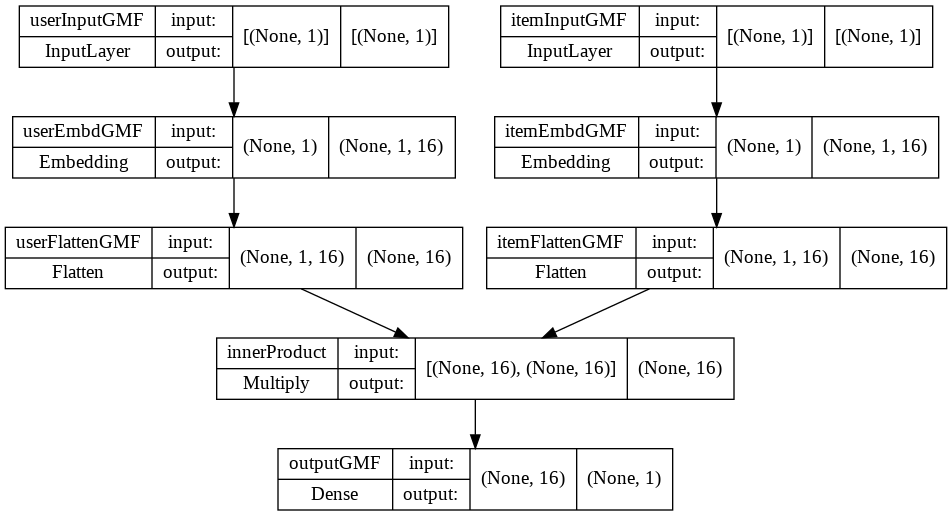

In [ ]:
!mkdir visual
# Print the model layers with input and output shapes of each layer
modelVisualization(GMFModels[latentFactor], 'visual/GMFModelFactor{}.png'.format(latentFactor))

In [ ]:
GMFModels[latentFactor].summary()

Model: "GMF"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 userInputGMF (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 itemInputGMF (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 userEmbdGMF (Embedding)        (None, 1, 16)        96640       ['userInputGMF[0][0]']           
                                                                                                  
 itemEmbdGMF (Embedding)        (None, 1, 16)        63232       ['itemInputGMF[0][0]']           
                                                                                                

# *12. MLP Model*

## Model Creation

### Methods

In [ ]:
# Method to create the GMF model

def createMLPModel(nUsers, nItems, predFactor, numHiddenLayers):
  # Initialize input layer for the users and the items
  userInput = keras.Input(shape=(1,), dtype='int32', name = 'userInputMLP')
  itemInput = keras.Input(shape=(1,), dtype='int32', name = 'itemInputMLP')

  hiddenLayers = createMLPModelLayers(nUsers, nItems, userInput, itemInput, predFactor, numHiddenLayers)
  
  outputs=layers.Dense(1, activation="sigmoid", kernel_initializer = initializers.LecunUniform, name='outputMLP')(hiddenLayers)
  
  model = keras.Model(inputs=[userInput, itemInput], outputs=outputs, name="MLP")
  
  return model

### Calls

In [ ]:
# Create the GMF model with a certain predictive factor
model = createMLPModel(nUsers, nItems, predictiveFactor, nHiddenLayers)

# Compile the model with a optimizer and a loss function
compileModel(model, learningRate)

MLPModels[predictiveFactor] = model

## Model Training and Evaluation

### Initialize Metrics Dictionary

In [ ]:
# Initialize the dictionary with default values

MLPmetricsDict[predictiveFactor] = [0, 0, 0, [], [], []]

### Initialize metrics

In [ ]:
metricsInitialization(MLPModels[predictiveFactor], MLPmetricsDict,
                      testSet, testWithNegSamples,
                      topK, predictiveFactor)

### Training and Evaluation Model

In [ ]:
weightsFilename, resultsFilename = getFilename(datasetName, Model.MLP.value, topK,
                              numNegSamplesTrain, predFactor=predictiveFactor, nHiddenLayers=nHiddenLayers)

with tf.device("/GPU:0"):
  trainAndEvaluate(MLPModels[predictiveFactor], MLPmetricsDict, weightsFilename,
                 resultsFilename, topK, epochs, numNegSamplesTrain,
                 testSet, testWithNegSamples, predictiveFactor,
                 saveModelWeights, evaluationRate)

files.download('results/' + resultsFilename)

Starting the training of the model...

Start of epoch 1
Generating training input vectors...
Starting the generation of new negative samples...
Successfully created model's training input vectors with negative samples
Training the model for one epoch with the generated vectors as inputs...

Epoch of training completed!

Epoch 1 completed with loss 0.33610111474990845
Saved the model weights for the current iteration

Start of epoch 2
Generating training input vectors...
Starting the generation of new negative samples...
Successfully created model's training input vectors with negative samples
Training the model for one epoch with the generated vectors as inputs...

Epoch of training completed!

Epoch 2 completed with loss 0.2981387674808502
Saved the model weights for the current iteration

Evaluating the model trained for 2 epochs...
At the epoch 2 the metrics are: 
hit ratio 0.6004966887417219 
ndcg 0.340025984045992 
loss 0.2981387674808502

Updated the best metrics values! 
Best me

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model Visualization

mkdir: cannot create directory ‘visual’: File exists


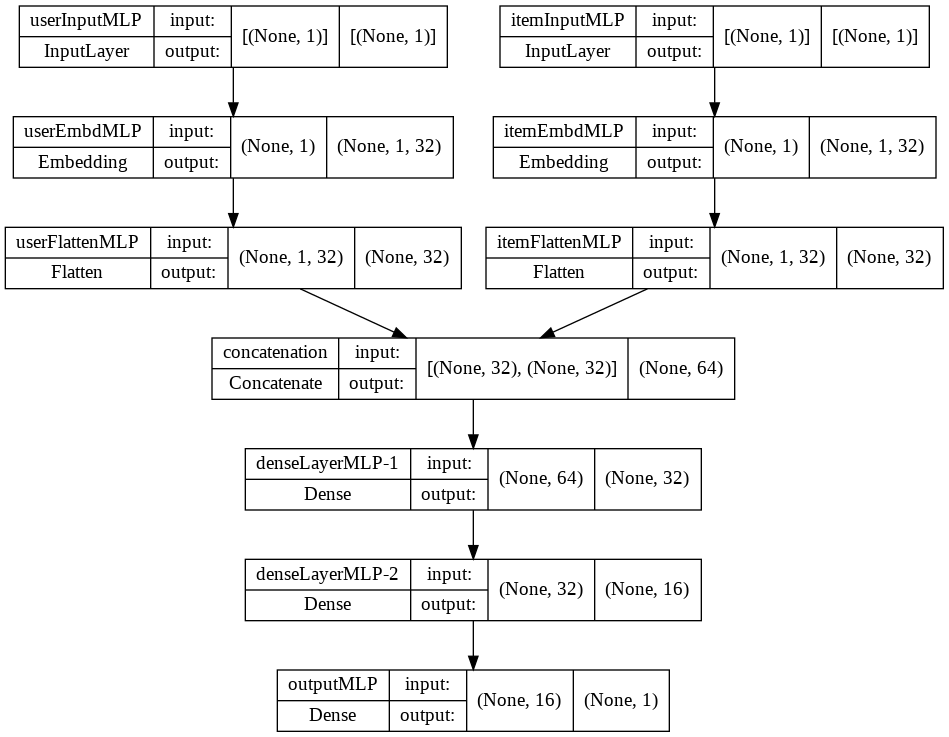

In [ ]:
!mkdir visual
# Print the model layers with input and output shapes of each layer
modelVisualization(MLPModels[predictiveFactor], 'visual/MLPModelFactor{}.png'.format(predictiveFactor))

In [ ]:
MLPModels[predictiveFactor].summary()

# *13. NeuMF Model*

## Model Creation

In [ ]:
modelName = Model.NeuMF.value

### Methods

In [ ]:
# Method to create NeuMF model

def createNeuMFModel(nUsers, nItems, predFactor, latentFactor, numHiddenLayers):
  # Initialize input layer for the users and the items
  userInput = keras.Input(shape=(1,), dtype='int32', name = 'userInput')
  itemInput = keras.Input(shape=(1,), dtype='int32', name = 'itemInput')

  # Create the layers for GMF and MLP models
  MLPLayers = createMLPModelLayers(nUsers, nItems, userInput, itemInput, predFactor, numHiddenLayers)
  GMFLayers = createGMFModelLayers(nUsers, nItems, userInput, itemInput, latentFactor)

  # Concatenate the outputs of the GMF and MLP models
  conc = layers.Concatenate(axis=1, name = 'concOutputsNeuMF')([GMFLayers, MLPLayers])

  # Sigmoid to generate the final output of the model 
  output = layers.Dense(1, activation = "sigmoid", kernel_initializer = initializers.LecunUniform, name = 'output')(conc)

  model = keras.Model(inputs=[userInput, itemInput], outputs=output, name="NeuMF")
  
  return model

### Calls

In [ ]:
# Create the NeuMF model with a certain number of MLP's hidden layers, predictive factor and latent factor
model = createNeuMFModel(nUsers, nItems, predictiveFactor, latentFactor, nHiddenLayers)
# model = createNeuMFModelDenseLayer(nUsers, nItems, predictiveFactor, latentFactor, nHiddenLayers)

# Compile the model with a optimizer and a loss function
compileModel(model, learningRate)

NeuMFModels[neuID] = model

## Pre-Training

In [ ]:
# To pre-train the NeuMF model, first set to true the respective flag
assert(preTrain == True)

### Fetch weights of build-in models

Run this cell only if you want to use the standard pre-trained weights of GMF and MLP taken from the github repository.

The standard parameters are:

*   topK = 10 
*   numNegSamplesTrain = 4
*   nHiddenLayers = 3






Otherwise, first create MLP and GMF models and pre-train them

In [ ]:
!mkdir pretrain

GMFweightsName, _ = getFilename(datasetName, Model.GMF.value, topK,
                             numNegSamplesTrain, latentFactor)
MLPweightsName, _ = getFilename(datasetName, Model.MLP.value, topK, numNegSamplesTrain,
                             predFactor = predictiveFactor, nHiddenLayers = nHiddenLayers)
GMFurl = weightsUrl(GMFweightsName, datasetName)
MLPurl = weightsUrl(MLPweightsName, datasetName)

_, _ = urllib.request.urlretrieve(GMFurl, 'pretrain/' + GMFweightsName)
_, _ = urllib.request.urlretrieve(MLPurl, 'pretrain/' + MLPweightsName)

### Setup Model

#### Methods

In [ ]:
def getModelsOutputWeights(latFactor, predFactor, nUsers, nItems, nLayers, dataset='MovieLens'):
  GMF = createGMFModel(nUsers, nItems, latFactor)
  MLP = createMLPModel(nUsers, nItems, predictiveFactor, nHiddenLayers)

  GMFweightsName, _ = getFilename(datasetName, Model.GMF.value, topK,
                             numNegSamplesTrain, latentFactor)
  MLPweightsName, _ = getFilename(datasetName, Model.MLP.value, topK, numNegSamplesTrain,
                             predFactor = predictiveFactor, nHiddenLayers = nHiddenLayers)

  # Load weights in the new GMF model instance by name
  GMF.load_weights('pretrain/' + GMFweightsName, by_name=True)

  # Get the output layer from the model instance
  GMFOutput = GMF.get_layer('outputGMF').get_weights()

  # Load weights in the new MLP model instance by name
  MLP.load_weights('pretrain/' + MLPweightsName, by_name=True)

  # Get the output layer from the model instance
  MLPOutput = MLP.get_layer('outputMLP').get_weights()

  return GMFOutput, MLPOutput

In [ ]:
def loadWeights(model, latFactor, predFactor, nUsers, nItems, nLayers, dataset='MovieLens'):

  GMFOutput, MLPOutput = getModelsOutputWeights(latFactor, predFactor, nUsers, nItems, nLayers, dataset)

  GMFweightsName, _ = getFilename(datasetName, Model.GMF.value, topK,
                             numNegSamplesTrain, latentFactor)
  MLPweightsName, _ = getFilename(datasetName, Model.MLP.value, topK, numNegSamplesTrain,
                             predFactor = predictiveFactor, nHiddenLayers = nHiddenLayers)

  # Load weights of NeuMF's GMF model layers by name 
  # (Weights of GMF's output layer are not taken because NeuMF doesn't have that layer)
  model.load_weights('pretrain/' + GMFweightsName, by_name=True)

  # Load weights of NeuMF's MLP model layers by name
  # (Weights of MLP's output layer are not taken because NeuMF doesn't have that layer)
  model.load_weights('pretrain/' + MLPweightsName, by_name=True)

  GMFOutWeights = GMFOutput[0]
  GMFOutBias = GMFOutput[1]

  MLPOutWeights = MLPOutput[0]
  MLPOutBias = MLPOutput[1]

  # Determine the NeuMF output layer's weights and bias from GMF and MLP output layers 
  NeuMFOutWeights = np.concatenate((alfa * GMFOutWeights, (1 - alfa) * MLPOutWeights), axis=0)
  NeuMFOutBias = alfa * GMFOutBias + (1 - alfa) * MLPOutBias

  # Set NeuMF output layer weights and bias
  model.get_layer('output').set_weights([NeuMFOutWeights, NeuMFOutBias])

In [ ]:
def loadWeightsNoAlpha(model, latFactor, predFactor, nUsers, nItems, nLayers, dataset='MovieLens'):

  GMFOutput, MLPOutput = getModelsOutputWeights(latFactor, predFactor, nUsers, nItems, nLayers, dataset)

  GMFweightsName, _ = getFilename(datasetName, Model.GMF.value, topK,
                             numNegSamplesTrain, latentFactor)
  MLPweightsName, _ = getFilename(datasetName, Model.MLP.value, topK, numNegSamplesTrain,
                             predFactor = predictiveFactor, nHiddenLayers = nHiddenLayers)

  # Load weights of NeuMF's GMF model layers by name 
  # (Weights of GMF's output layer are not taken because NeuMF doesn't have that layer)
  model.load_weights('pretrain/' + GMFweightsName, by_name=True)

  # Load weights of NeuMF's MLP model layers by name
  # (Weights of MLP's output layer are not taken because NeuMF doesn't have that layer)
  model.load_weights('pretrain/' + MLPweightsName, by_name=True)

  GMFOutWeights = GMFOutput[0]
  GMFOutBias = GMFOutput[1]

  MLPOutWeights = MLPOutput[0]
  MLPOutBias = MLPOutput[1]

  # Determine the NeuMF output layer's weights and bias from GMF and MLP output layers 
  NeuMFOutWeights = np.concatenate((GMFOutWeights, MLPOutWeights), axis=0)
  NeuMFOutBias = GMFOutBias + MLPOutBias

  # Set NeuMF output layer weights and bias
  model.get_layer('output').set_weights([NeuMFOutWeights, NeuMFOutBias])

In [ ]:
# Method that set all layers to not trainable except the output layer

def freezeLayers(model):
  for i in range(len(model.layers)-1):
    model.layers[i].trainable=False

#### Calls

In [ ]:
fineTuningLearnRate = learningRateOptions[0]

NeuMFModels[neuIDPretrain] = createNeuMFModel(nUsers, nItems, predictiveFactor, latentFactor, nHiddenLayers)

# Compile the model with a optimizer and a loss function
compileModel(NeuMFModels[neuIDPretrain], fineTuningLearnRate, optimizer=Optimizer.SGD)

loadWeights(NeuMFModels[neuIDPretrain], latentFactor, predictiveFactor, nUsers, nItems, nHiddenLayers, datasetName)

freezeLayers(NeuMFModels[neuIDPretrain])

## Model Training and Evaluation

### Initialize Metrics Dictionary

In [ ]:
if preTrain:
  NeuMFmetricsDict[neuIDPretrain] = [0, 0, 0, [], [], []]
else: NeuMFmetricsDict[neuID] = [0, 0, 0, [], [], []]

### Initialize metrics

In [ ]:
if preTrain:
  metricsInitialization(NeuMFModels[neuIDPretrain], NeuMFmetricsDict,
                        testSet, testWithNegSamples,
                        topK, neuIDPretrain)
else: metricsInitialization(NeuMFModels[neuID], NeuMFmetricsDict,
                            testSet, testWithNegSamples,
                            topK, neuID)

Evaluation without training of the model...
Hit ratio: 0.6968543046357616 
NDCG: 0.42174275387521987



### Training and Evaluation Model

In [ ]:
weightsFilename, resultsFilename = getFilename(datasetName, Model.NeuMF.value, topK,
                              numNegSamplesTrain, latentFactor, predictiveFactor, nHiddenLayers, preTrain)

with tf.device("/GPU:0"):
  if preTrain:
    print('Started the training of NeuMF with Pretrain!')
    trainAndEvaluate(NeuMFModels[neuIDPretrain], NeuMFmetricsDict, weightsFilename,
              resultsFilename, topK, epochs, numNegSamplesTrain,
              testSet, testWithNegSamples, neuIDPretrain,
              saveModelWeights, evaluationRate)
  else:
    print('Started the training of NeuMF!')
    trainAndEvaluate(NeuMFModels[neuID], NeuMFmetricsDict, weightsFilename,
              resultsFilename, topK, epochs, numNegSamplesTrain,
              testSet, testWithNegSamples, neuID,
              saveModelWeights, evaluationRate)

files.download('results/' + resultsFilename)

Started the training of NeuMF!
Starting the training of the model...

Start of epoch 1
Generating training input vectors...
Starting the generation of new negative samples...
Successfully created model's training input vectors with negative samples
Training the model for one epoch with the generated vectors as inputs...

Epoch of training completed!

Epoch 1 completed with loss 0.3036276400089264
Saved the model weights for the current iteration

Start of epoch 2
Generating training input vectors...
Starting the generation of new negative samples...
Successfully created model's training input vectors with negative samples
Training the model for one epoch with the generated vectors as inputs...

Epoch of training completed!

Epoch 2 completed with loss 0.25768324732780457
Saved the model weights for the current iteration

Evaluating the model trained for 2 epochs...
At the epoch 2 the metrics are: 
hit ratio 0.6690397350993378 
ndcg 0.39588359289010977 
loss 0.25768324732780457

Updated

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model Visualization

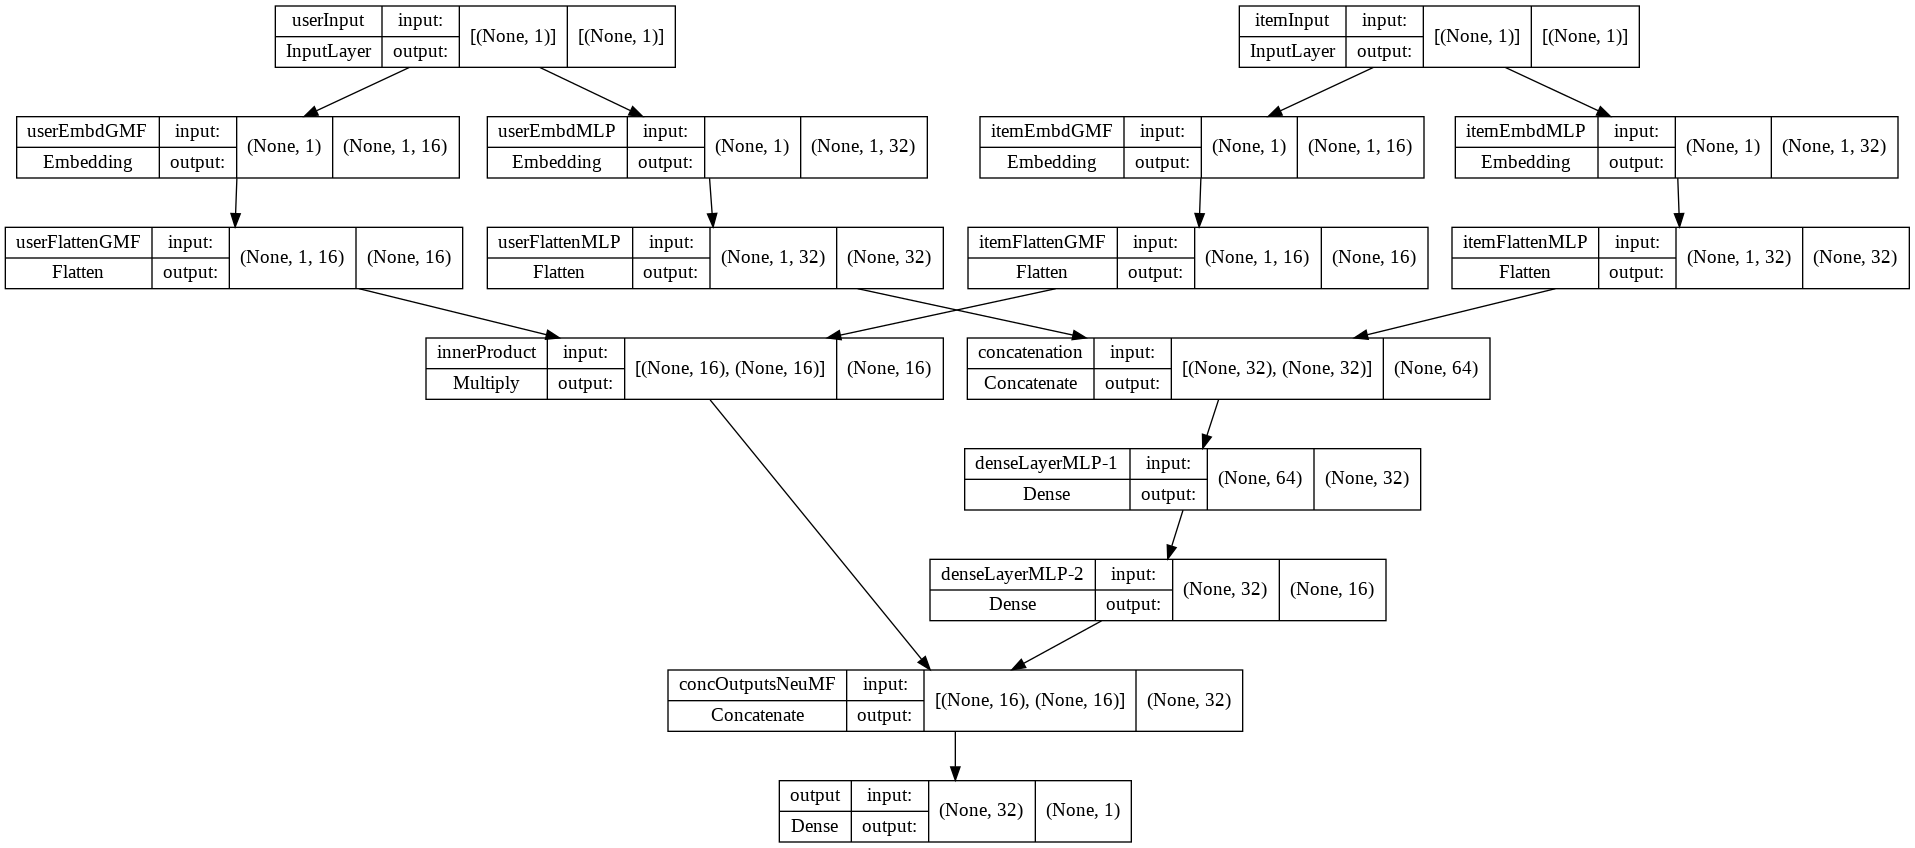

In [ ]:
!mkdir visual
modelVisualization(NeuMFModels[neuID], 'visual/NeuMF{}.png'.format(neuID))

In [ ]:
NeuMFModels[neuID].summary()

Model: "NeuMF"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 userInput (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 itemInput (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 userEmbdMLP (Embedding)        (None, 1, 32)        193280      ['userInput[0][0]']              
                                                                                                  
 itemEmbdMLP (Embedding)        (None, 1, 32)        126464      ['itemInput[0][0]']              
                                                                                              

# 14. *Experiments*

##MovieLens

### Metrics Varying Factor

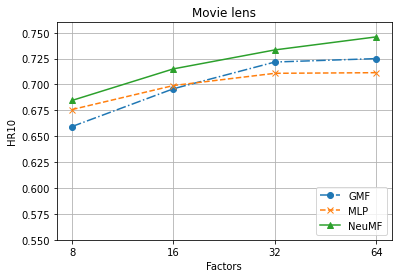

In [ ]:
factors = [8, 16, 32, 64]
x=[1,2,3,4]

hitrGMF = [0.6594, 0.6959, 0.7217, 0.725]
hitrMLP = [0.6758, 0.6990, 0.7108, 0.7114]
# pretrain
hitrNeu = [0.6846, 0.7151, 0.7334, 0.7460]

plt.plot(x, hitrGMF, linestyle='dashdot', marker='o')
plt.plot(x, hitrMLP, linestyle='dashed', marker='x')
plt.plot(x, hitrNeu, marker='^')
plt.ylim(ymin=0.55,ymax=0.76)
plt.title('Movie lens')
plt.ylabel('HR10')
plt.xlabel('Factors')
plt.legend(['GMF', 'MLP', 'NeuMF'], loc='lower right')
plt.xticks(x, factors)
plt.grid()

plt.savefig('HRMovieLensFactor.png', bbox_inches='tight')
plt.show()

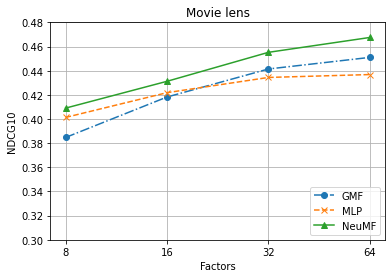

In [ ]:
factors = [8, 16, 32, 64]
x=[1,2,3,4]
ndcgGMF = [0.3847, 0.4182, 0.4414, 0.4510]
ndcgMLP = [0.4013, 0.4218, 0.4344, 0.4368]
# pretrain
ndcgNeu = [0.4090, 0.4312, 0.4552, 0.4675]

plt.plot(x, ndcgGMF, linestyle='dashdot',marker='o')
plt.plot(x, ndcgMLP, linestyle='dashed',marker='x')
plt.plot(x, ndcgNeu,marker='^')
plt.ylim(ymin=0.3,ymax=0.48)

plt.title('Movie lens')
plt.ylabel('NDCG10')
plt.xlabel('Factors')
plt.legend(['GMF', 'MLP', 'NeuMF'], loc='lower right')
plt.xticks(x, factors)
plt.grid()

plt.savefig('NDCGMovieLensFactor.png', bbox_inches='tight')
plt.show()

### Varying K in top K

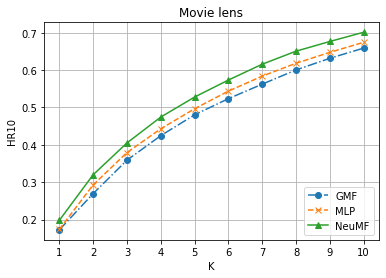

In [ ]:
k = list(range(1,11))

hitrGMF = [0.1724, 0.2694, 0.3589, 0.4245, 0.4803, 
           0.5235, 0.5623, 0.6003, 0.6315, 0.6588]
hitrMLP = [0.1738, 0.2927, 0.3793, 0.4429, 0.4965,
           0.5437, 0.5838, 0.6182, 0.6474, 0.6742]
hitrNeu = [0.1978, 0.3199, 0.4050, 0.4742, 0.5278,
           0.5733, 0.6157, 0.6505, 0.6765, 0.7012]

plt.plot(k, hitrGMF, linestyle='dashdot',marker='o')
plt.plot(k, hitrMLP, linestyle='dashed',marker='x')
plt.plot(k, hitrNeu,marker='^')
plt.xticks(k)

plt.title('Movie lens')
plt.ylabel('HR10')
plt.xlabel('K')
plt.legend(['GMF', 'MLP', 'NeuMF'], loc='lower right')
plt.grid()
plt.savefig('HRMovieLensTopK.png', bbox_inches='tight')


plt.show()

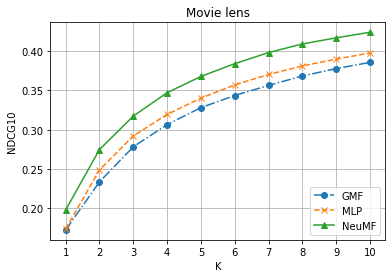

In [ ]:
k = list(range(1,11))

ndcgGMF = [0.1724, 0.2336, 0.2783, 0.3066, 0.3282,
           0.3436, 0.3565, 0.3685, 0.3779, 0.3858]
ndcgMLP = [0.1738, 0.2488, 0.2921, 0.3195, 0.3403,
           0.3571, 0.3704, 0.3813, 0.3900, 0.3978]
ndcgNeu = [0.1978, 0.2748, 0.3174, 0.3472, 0.3679,
           0.3842, 0.3983, 0.4093, 0.4171, 0.4242]

plt.plot(k, ndcgGMF, linestyle='dashdot',marker='o')
plt.plot(k, ndcgMLP, linestyle='dashed',marker='x')
plt.plot(k, ndcgNeu,marker='^')
plt.xticks(k)

plt.title('Movie lens')
plt.ylabel('NDCG10')
plt.xlabel('K')
plt.legend(['GMF', 'MLP', 'NeuMF'], loc='lower right')
plt.grid()

plt.savefig('NDCGMovieLensTopK.png', bbox_inches='tight')
plt.show()

### Varying Number of Negative Samples in Train set

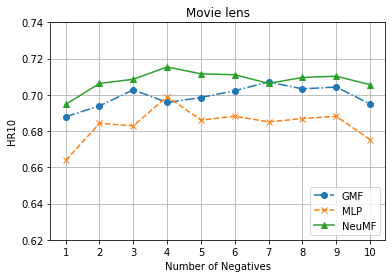

In [ ]:
numNegSamples = list(range(1,11))

hitrGMF = [0.6879, 0.6939, 0.7028, 0.6958, 0.6985,
           0.7023, 0.7071, 0.7033, 0.7043, 0.6950]
hitrMLP = [0.6638, 0.6843, 0.6829, 0.6990, 0.6861,
           0.6882, 0.6851, 0.6869, 0.6882, 0.6753]
hitrNeu = [0.6947, 0.7063, 0.7086, 0.7154, 0.7116,
           0.7111, 0.7063, 0.7096, 0.7103, 0.7056]

plt.plot(numNegSamples, hitrGMF, linestyle='dashdot',marker='o')
plt.plot(numNegSamples, hitrMLP, linestyle='dashed',marker='x')
plt.plot(numNegSamples, hitrNeu,marker='^')
plt.xticks(k)
plt.ylim(ymin=0.62,ymax=0.74)
plt.title('Movie lens')
plt.ylabel('HR10')
plt.xlabel('Number of Negatives')
plt.legend(['GMF', 'MLP', 'NeuMF'], loc='lower right')
plt.grid()

plt.savefig('HRMovieLensNegSample.png', bbox_inches='tight')

plt.show()

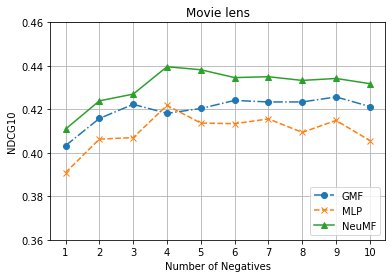

In [ ]:
numNegSamples = list(range(1,11))

ndcgGMF = [0.4033, 0.4158, 0.4223, 0.41815, 0.4204,
           0.4241, 0.4234, 0.4234, 0.4257, 0.4213]
ndcgMLP = [0.3909, 0.4063, 0.4070, 0.4218, 0.4137,
           0.4134, 0.4156, 0.4094, 0.4149, 0.4056]
ndcgNeu = [0.4109, 0.4239, 0.4270, 0.4396, 0.4382,
           0.4346, 0.4350, 0.4333, 0.4342, 0.4318]

plt.plot(numNegSamples, ndcgGMF, linestyle='dashdot',marker='o')
plt.plot(numNegSamples, ndcgMLP, linestyle='dashed',marker='x')
plt.plot(numNegSamples, ndcgNeu,marker='^')
plt.xticks(k)
plt.ylim(ymin=0.36,ymax=0.46)
plt.title('Movie lens')
plt.ylabel('NDCG10')
plt.xlabel('Number of Negatives')
plt.legend(['GMF', 'MLP', 'NeuMF'], loc='lower right')
plt.grid()

plt.savefig('NDCGMovieLensNegSample.png', bbox_inches='tight')
plt.show()

### Every Iter

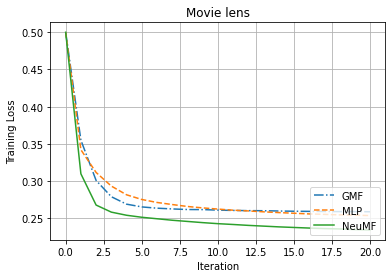

In [ ]:
iter = list(range(0,21))

lossGMF = [0.5, 0.3550,0.3009,0.2790,0.2690,0.2653,0.2636,
           0.2626,0.2618,0.2617,0.2610,0.2606,0.2603,
           0.2602,0.2598,0.2595,0.2593,0.2592,0.2590,
           0.2590,0.2588]
lossMLP = [0.5, 0.3421,0.3116,0.2933,0.2816,0.2753,0.2713,
           0.2685,0.2659,0.2640,0.2624,0.2609,0.2599,
           0.2587,0.2577,0.2568,0.2559,0.2553,0.2546,
           0.2542,0.2537]
lossNeu = [0.5, 0.3098,0.2678,0.2583,0.2541,0.2514,0.2494,
           0.2474,0.2458,0.2442,0.2428,0.2417,0.2405,
           0.2395,0.2385,0.2377,0.2369,0.2362,0.2357,
           0.2349,0.2344]

plt.plot(iter, lossGMF, linestyle='dashdot')
plt.plot(iter, lossMLP, linestyle='dashed')
plt.plot(iter, lossNeu)


plt.title('Movie lens')
plt.ylabel('Training Loss')
plt.xlabel('Iteration')
plt.legend(['GMF', 'MLP', 'NeuMF'], loc='lower right')
plt.grid()

plt.savefig('LossMovieLens.png', bbox_inches='tight')
plt.show()

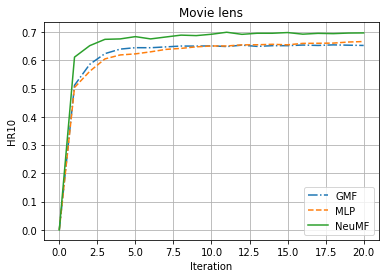

In [ ]:
iter = list(range(0,21))
hitrGMF = [0, 0.5118,0.5859,0.6237,0.6396,0.6447,0.6445,
           0.6475,0.6505,0.6502,0.6512,0.6487,0.6536,
           0.6493,0.6517,0.6518,0.6540,0.6526,0.6546,
           0.6535,0.6526]
hitrMLP = [0, 0.5038,0.5611,0.6050,0.6190,0.6228,0.6300,
           0.6386,0.6422,0.6477,0.6507,0.6507,0.6546,
           0.6550,0.6566,0.6548,0.6599,0.6603,0.6609,
           0.6647,0.6664]
hitrNeu = [0, 0.6113,0.6518,0.6742,0.6757,0.6838,0.6757,
           0.6825,0.6891,0.6874,0.6922,0.6993,0.6919,
           0.6957,0.6957,0.6982,0.6925,0.6954,0.6944,
           0.6964,0.6969]

plt.plot(iter, hitrGMF, linestyle='dashdot')
plt.plot(iter, hitrMLP, linestyle='dashed')
plt.plot(iter, hitrNeu)

plt.title('Movie lens')
plt.ylabel('HR10')
plt.xlabel('Iteration')
plt.legend(['GMF', 'MLP', 'NeuMF'], loc='lower right')
plt.grid()

plt.savefig('HRMovieLensEveryIter.png', bbox_inches='tight')
plt.show()

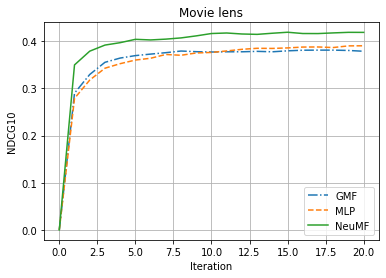

In [ ]:
iter = list(range(0,21))

ndcgGMF = [0, 0.2898,0.3293,0.3551,0.3641,0.3693,0.3725,
           0.3755,0.3790,0.3776,0.3769,0.3774,0.3774,
           0.3783,0.3774,0.3794,0.3807,0.3809,0.3809,
           0.3802,0.3785]
ndcgMLP = [0, 0.2787,0.3175,0.3426,0.3522,0.3599,0.3637,
           0.3717,0.3700,0.3749,0.3760,0.3792,0.3826,
           0.3848,0.3845,0.3856,0.3874,0.3876,0.3864,
           0.3899,0.3901]
ndcgNeu = [0, 0.3496,0.3787,0.3916,0.3967,0.4038,0.4025,
           0.4042,0.4068,0.4111,0.4161,0.4172,0.4151,
           0.4143,0.4167,0.4188,0.4161,0.4160,0.4174,
           0.4186,0.4185]

plt.plot(iter, ndcgGMF, linestyle='dashdot')
plt.plot(iter, ndcgMLP, linestyle='dashed')
plt.plot(iter, ndcgNeu)

plt.title('Movie lens')
plt.ylabel('NDCG10')
plt.xlabel('Iteration')
plt.legend(['GMF', 'MLP', 'NeuMF'], loc='lower right')
plt.grid()

plt.savefig('NDCGMovieLensEveryIter.png', bbox_inches='tight')
plt.show()

### PreTrain vs No PreTrain Table

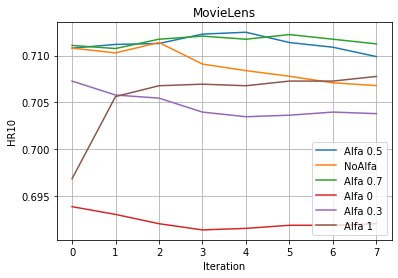

In [ ]:
iter = list(range(0,8))

alfa = [0.7108,0.7112,0.7113,0.7123,0.7125,0.7114,0.7109,0.7099]
noAlfa = [0.7108,0.7103,0.7114,0.7091,0.7084,0.7078,0.7071,0.7068]
alfa07 = [0.7110927152317881,0.7107615894039735,0.7117549668874172,0.7120860927152318,0.7117549668874172,0.7122516556291391,0.7117549668874172,0.7112582781456953]
alfa0 = [0.6938741721854305,0.6930463576158941,0.6920529801324503,0.6913907284768211,0.6915562913907285,0.6918874172185431,0.6918874172185431,0.6920529801324503]
alfa03 = [0.7072847682119205,0.705794701986755,0.7054635761589404,0.7039735099337748,0.703476821192053,0.7036423841059603,0.7039735099337748,0.7038079470198676]
alfa1 = [0.6968543046357616,0.7056291390728476,0.7067880794701987,0.706953642384106,0.7067880794701987,0.7072847682119205,0.7072847682119205,0.7077814569536424]

plt.plot(iter, alfa, )
plt.plot(iter, noAlfa)
plt.plot(iter, alfa07)
plt.plot(iter, alfa0)
plt.plot(iter, alfa03)
plt.plot(iter, alfa1)

plt.title('MovieLens')
plt.ylabel('HR10')
plt.xlabel('Iteration')
plt.legend(['Alfa 0.5', 'NoAlfa', 'Alfa 0.7', 'Alfa 0', 'Alfa 0.3', 'Alfa 1'], loc='lower right')
plt.grid()

plt.savefig('PretrainingVariations.png', bbox_inches='tight')
plt.show()

In [ ]:
factors = [8, 16, 32, 64]
tags = ['Pre-train HR10', 'Pre-train NDCG10', 'No Pre-train HR10', 'No Pre-train NDCG10']

neuStandardHR = [0.7043, 0.7116, 0.7197, 0.7277]
neuStandardNDCG = [0.4246, 0.4396, 0.4489, 0.4498]
neuPretrainHR = [0.6846, 0.7151, 0.7334, 0.7460]
neuPretrainNDCG = [0.4090, 0.4412, 0.4552, 0.4675]

data = np.matrix((neuPretrainHR, neuPretrainNDCG,
                  neuStandardHR, neuStandardNDCG))

data = np.transpose(data)

pretrainComp = pd.DataFrame(data, columns=tags, index=factors)
display(pretrainComp)

,Pre-train HR10,Pre-train NDCG10,No Pre-train HR10,No Pre-train NDCG10
8,0.6846,0.4090,0.7043,0.4246
16,0.7151,0.4412,0.7116,0.4396
32,0.7334,0.4552,0.7197,0.4489
64,0.7460,0.4675,0.7277,0.4498


### MLP with different layers table

In [ ]:
#HR
factors = [8, 16, 32, 64]
tags = ['MLP-0', 'MLP-1', 'MLP-2', 'MLP-3', 'MLP-4']

mlp0 = [0.4692, 0.4692, 0.4685, 0.4685]
mlp1 = [0.5960, 0.6627, 0.6921, 0.7011]
mlp2 = [0.6758, 0.6890, 0.7008, 0.7034]
mlp3 = [0.6907, 0.6983, 0.7063, 0.7121]
mlp4 = [0.7040, 0.7084, 0.7114, 0.7145]

data = np.matrix((mlp0, mlp1, mlp2, mlp3, mlp4))

data = np.transpose(data)

mlpComp = pd.DataFrame(data, columns=tags, index=factors)
display(mlpComp)

,MLP-0,MLP-1,MLP-2,MLP-3,MLP-4
8,0.4692,0.5960,0.6758,0.6907,0.7040
16,0.4692,0.6627,0.6890,0.6983,0.7084
32,0.4685,0.6921,0.7008,0.7063,0.7114
64,0.4685,0.7011,0.7034,0.7121,0.7145


In [ ]:
#NDCG
factors = [8, 16, 32, 64]
tags = ['MLP-0', 'MLP-1', 'MLP-2', 'MLP-3', 'MLP-4']

mlp0 = [0.2612,0.2611,0.2601,0.2609]
mlp1 = [0.3395,0.3907,0.4131,0.4317]
mlp2 = [0.4013, 0.4218, 0.4344, 0.4368]
mlp3 = [0.4162,0.4229,0.43667,0.4404]
mlp4 = [0.4292,0.4359,0.4417,0.4455]

data = np.matrix((mlp0, mlp1, mlp2, mlp3, mlp4))

data = np.transpose(data)

mlpComp = pd.DataFrame(data, columns=tags, index=factors)
display(mlpComp)

,MLP-0,MLP-1,MLP-2,MLP-3,MLP-4
8,0.2612,0.3395,0.4013,0.41620,0.4292
16,0.2611,0.3907,0.4218,0.42290,0.4359
32,0.2601,0.4131,0.4344,0.43667,0.4417
64,0.2609,0.4317,0.4368,0.44040,0.4455


##Pinterest


###Metrics Varying Factor Pinterest

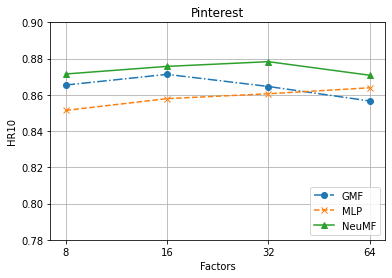

In [ ]:
factors = [8, 16, 32, 64]
x=[1,2,3,4]
hitrGMF = [0.8654,0.8713,0.8646,0.8566]
hitrMLP = [0.8514,0.8579,0.8606,0.8639]
hitrNeu = [0.8715,0.8757,0.8783,0.8708]

plt.plot(x, hitrGMF, linestyle='dashdot',marker='o')
plt.plot(x, hitrMLP, linestyle='dashed',marker='x')
plt.plot(x, hitrNeu,marker='^')
plt.ylim(ymin=0.78,ymax=0.9)
plt.title('Pinterest')
plt.ylabel('HR10')
plt.xlabel('Factors')
plt.legend(['GMF', 'MLP', 'NeuMF'], loc='lower right')
plt.xticks(x, factors)
plt.grid()
plt.savefig('HRPinterestFactor.png', bbox_inches='tight')


plt.show()

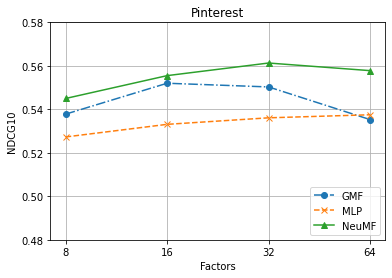

In [ ]:
factors = [8, 16, 32, 64]
x=[1,2,3,4]
ndcgGMF = [0.5378,0.5520,0.5503,0.5353]
ndcgMLP= [0.5273,0.5331,0.5361,0.5375]
ndcgNeu = [0.5450,0.5555,0.5613,0.5578]


plt.plot(x, ndcgGMF, linestyle='dashdot',marker='o')
plt.plot(x, ndcgMLP, linestyle='dashed',marker='x')
plt.plot(x, ndcgNeu,marker='^')
plt.ylim(ymin=0.48,ymax=0.58)
plt.title('Pinterest')
plt.ylabel('NDCG10')
plt.xlabel('Factors')
plt.legend(['GMF', 'MLP', 'NeuMF'], loc='lower right')
plt.xticks(x, factors)
plt.grid()

plt.savefig('NDCGMovieLensFactor.png', bbox_inches='tight')
plt.show()

###Varying K in top K Pinterest

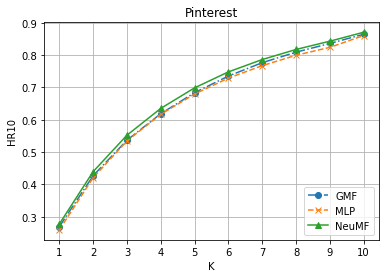

In [ ]:
k = list(range(1,11))

hitrGMF = [0.2690,0.4268,0.5366,0.6187,0.6838,0.7352,
           0.7766,0.8091,0.8361,0.8646]
hitrMLP = [0.2591, 0.4206, 0.5345,0.6168,0.6795,
           0.7289,0.7674,0.7996,0.8240,0.8606]
hitrNeu = [0.2772,0.4394,0.5521,0.6351,0.6987,0.7481,
           0.7863,0.8175,0.8431,0.8708]
plt.plot(k, hitrGMF, linestyle='dashdot',marker='o')
plt.plot(k, hitrMLP, linestyle='dashed',marker='x')
plt.plot(k, hitrNeu,marker='^')
plt.xticks(k)

plt.title('Pinterest')
plt.ylabel('HR10')
plt.xlabel('K')
plt.legend(['GMF', 'MLP', 'NeuMF'], loc='lower right')
plt.grid()
plt.savefig('HRPinterestTopK.png', bbox_inches='tight')

plt.show()

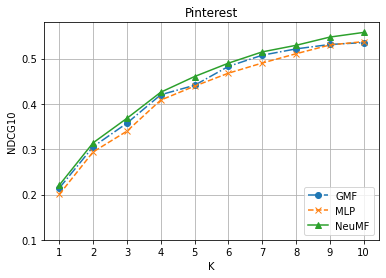

In [ ]:
k = list(range(1,11))


hitrGMF = [0.2141,0.3054,0.3574,0.4202,0.4411,0.4827,
           0.5075,0.5214,0.5312,0.5353]
hitrMLP = [0.2002,0.2940,0.3398,0.4085,0.4392,0.4678,
           0.4902,0.5107,0.5301,0.5375]
hitrNeu = [0.2207,0.3141,0.3682,0.4258,0.4604,0.4899,
           0.5148,0.5293,0.5475,0.5578]
plt.plot(k, hitrGMF, linestyle='dashdot',marker='o')
plt.plot(k, hitrMLP, linestyle='dashed',marker='x')
plt.plot(k, hitrNeu,marker='^')
plt.xticks(k)
plt.ylim(ymin=0.1,ymax=0.58)
plt.title('Pinterest')
plt.ylabel('NDCG10')
plt.xlabel('K')
plt.legend(['GMF', 'MLP', 'NeuMF'], loc='lower right')
plt.grid()

plt.savefig('NDCGPinterestTopK.png', bbox_inches='tight')
plt.show()

###Varying Number of Negative Samples in Train set Pinterest

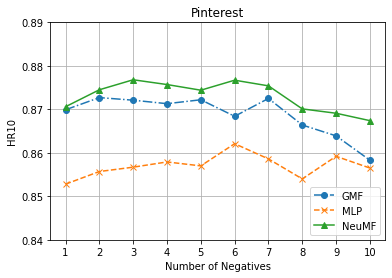

In [ ]:
numNegSamples = list(range(1,11))
hitrGMF = [0.8699,0.8727,0.8721,0.8713,0.8722,0.8684,
           0.8725,0.8664,0.8639,0.8583]
hitrMLP = [0.8528,0.8557,0.8567,0.8579,0.8570,0.8621,
           0.8586,0.8540,0.8592,0.8565]
hitrNeu = [0.8706,0.8745,0.8768,0.8757,0.8744,0.8767,
           0.8754,0.8701,0.8691,0.8674]
plt.plot(numNegSamples, hitrGMF, linestyle='dashdot',marker='o')
plt.plot(numNegSamples, hitrMLP, linestyle='dashed',marker='x')
plt.plot(numNegSamples, hitrNeu,marker='^')
plt.ylim(ymin=0.84,ymax=0.89)
plt.xticks(k)
plt.title('Pinterest')
plt.ylabel('HR10')
plt.xlabel('Number of Negatives')
plt.legend(['GMF', 'MLP', 'NeuMF'], loc='lower right')
plt.grid()
plt.savefig('HRPinterestNegSample.png', bbox_inches='tight')

plt.show()

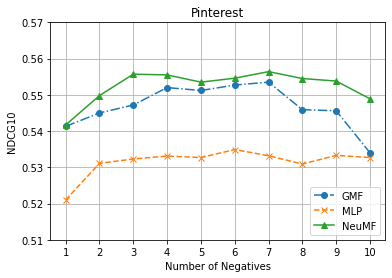

In [ ]:
numNegSamples = list(range(1,11))
ndcgGMF = [0.5413,0.5450,0.5472,0.5520,0.5512,0.5527,
           0.5535,0.5459,0.5456,0.5340]
ndcgMLP = [0.5210,0.5311,0.5323,0.5331,0.5327,0.5349,
           0.5332,0.5309,0.5333,0.5327]
ndcgNeu = [0.5417,0.5498,0.5557,0.5555,0.5535,0.5546,
           0.5564,0.5545,0.5538,0.5489]
plt.plot(numNegSamples, ndcgGMF, linestyle='dashdot',marker='o')
plt.plot(numNegSamples, ndcgMLP, linestyle='dashed',marker='x')
plt.plot(numNegSamples, ndcgNeu,marker='^')
plt.ylim(ymin=0.51,ymax=0.57)
plt.xticks(k)
plt.title('Pinterest')
plt.ylabel('NDCG10')
plt.xlabel('Number of Negatives')
plt.legend(['GMF', 'MLP', 'NeuMF'], loc='lower right')
plt.grid()
plt.savefig('NDCGPinterestNegSample.png', bbox_inches='tight')

plt.show()

###MLP with different layers table

In [ ]:
factors = [8, 16, 32, 64]
tags = ['MLP-0', 'MLP-1', 'MLP-2', 'MLP-3', 'MLP-4']
mlp0 = [0.2745,0.2743,0.2737,0.2741]
mlp1 = [0.8478,0.8502,0.8587,0.8629]
mlp2 = [0.8514,0.8579,0.8606,0.8639]
mlp3 = [0.8592,0.8617,0.8628,0.8644]
mlp4 = [0.8619,0.8636,0.8626,0.8663]

data = np.matrix((mlp0, mlp1, mlp2, mlp3, mlp4))

data = np.transpose(data)

mlpComp = pd.DataFrame(data, columns=tags, index=factors)
display(mlpComp)

,MLP-0,MLP-1,MLP-2,MLP-3,MLP-4
8,0.2745,0.8478,0.8514,0.8592,0.8619
16,0.2743,0.8502,0.8579,0.8617,0.8636
32,0.2737,0.8587,0.8606,0.8628,0.8626
64,0.2741,0.8629,0.8639,0.8644,0.8663


In [ ]:
factors = [8, 16, 32, 64]
tags = ['MLP-0', 'MLP-1', 'MLP-2', 'MLP-3', 'MLP-4']
mlp0 = [0.1292,0.1295,0.1294,0.1292]
mlp1 = [0.5192,0.5243,0.5298,0.5302]
mlp2 = [0.5273,0.5331,0.5361,0.5375]
mlp3 = [0.5284,0.5358,0.5374,0.5387]
mlp4 = [0.5294,0.5372,0.5384,0.5395]

data = np.matrix((mlp0, mlp1, mlp2, mlp3, mlp4))

data = np.transpose(data)

mlpComp = pd.DataFrame(data, columns=tags, index=factors)
display(mlpComp)

,MLP-0,MLP-1,MLP-2,MLP-3,MLP-4
8,0.1292,0.5192,0.5273,0.5284,0.5294
16,0.1295,0.5243,0.5331,0.5358,0.5372
32,0.1294,0.5298,0.5361,0.5374,0.5384
64,0.1292,0.5302,0.5375,0.5387,0.5395


###PreTrain vs No PreTrain Table Pinterest

In [ ]:
factors = [8, 16, 32, 64]
tags = ['Pre-train HR10', 'Pre-train NDCG10', 'No Pre-train HR10', 'No Pre-train NDCG10']

neuStandardHR = [0.8671,0.8675,0.8679,0.8687]
neuStandardNDCG = [0.5431, 0.5473, 0.5479, 0.5483]
neuPretrainHR = [0.8715,0.8757,0.8783,0.8708]
neuPretrainNDCG = [0.5450,0.5555,0.5613,0.5578]

data = np.matrix((neuPretrainHR, neuPretrainNDCG,
                  neuStandardHR, neuStandardNDCG))

data = np.transpose(data)

pretrainComp = pd.DataFrame(data, columns=tags, index=factors)
display(pretrainComp)

,Pre-train HR10,Pre-train NDCG10,No Pre-train HR10,No Pre-train NDCG10
8,0.8715,0.5450,0.8671,0.5431
16,0.8757,0.5555,0.8675,0.5473
32,0.8783,0.5613,0.8679,0.5479
64,0.8708,0.5578,0.8687,0.5483
